## Data Preprocessing

##### Importing the required libraries

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [29]:
data = pd.read_parquet("data.parquet")
data.head()

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27


In [30]:
data.tail()

,banknifty,nifty,tte
time,,,
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28
2022-06-30 15:29:00,0.243426,0.216455,28
2022-06-30 15:30:00,0.241907,0.216081,28


In [31]:
data.shape

(690512, 3)

In [32]:
data.isnull().sum()

banknifty    1500
nifty        2000
tte             0
dtype: int64

In [33]:
data.reset_index(inplace=True)

##### Computing missing values using KNN as it will not effect the original distribution of the actual data

In [34]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)  # Adjust n_neighbors as needed

imputer.fit(data[["banknifty", "nifty", "tte"]])

df_filled = imputer.transform(data[["banknifty", "nifty", "tte"]])

df_filled = pd.DataFrame(df_filled, columns=data[["banknifty", "nifty", "tte"]].columns)


In [35]:
df = pd.concat((df_filled, data["time"]), axis = 1)

In [36]:
df.head()

,banknifty,nifty,tte,time
0,0.286058,0.199729,27.0,2021-01-01 09:15:00
1,0.285381,0.200433,27.0,2021-01-01 09:16:00
2,0.284233,0.200004,27.0,2021-01-01 09:17:00
3,0.286104,0.199860,27.0,2021-01-01 09:18:00
4,0.285539,0.198951,27.0,2021-01-01 09:19:00


## z-score based trading system

##### Scaling it by 100 as values are very low, while calculating standard deviation for very small value it is convertig it to zero leads to computational error for z score

In [37]:
df["banknifty"]=df.banknifty.apply(lambda x:x*100)
df["nifty"]=df.nifty.apply(lambda x:x*100)

In [38]:
import warnings
warnings.filterwarnings("ignore")
df["spread"] = df["banknifty"] - df["nifty"]

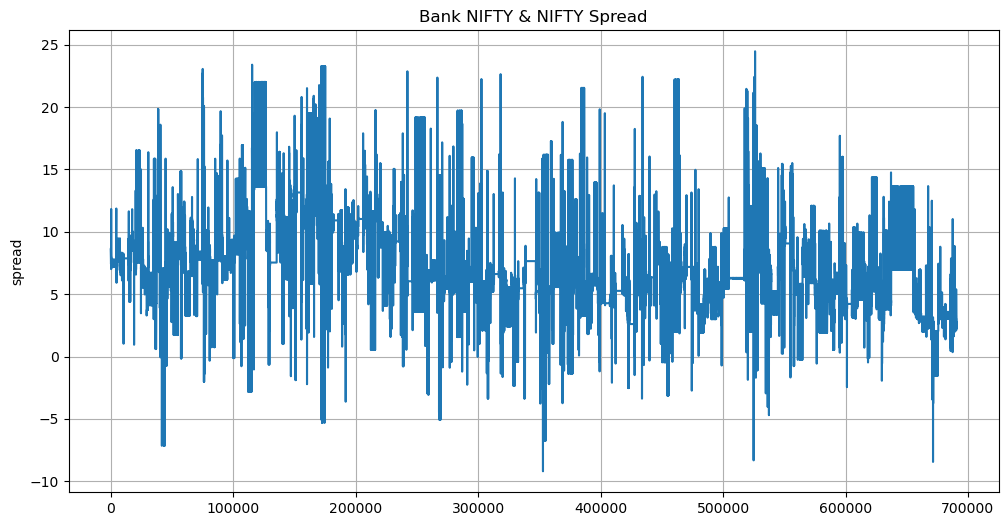

In [39]:
ax = df["spread"].plot(figsize=(12, 6), title = "Bank NIFTY & NIFTY Spread")
ax.set_ylabel("spread")
ax.grid(True)

In [40]:
from scipy import stats
window = 1440 #Taking 1 day i.e. equals to 1440 mins 
df["spread_mean"] = df["spread"].rolling(window).mean()
df["spread_std"] = df["spread"].rolling(window).std()

##### We are taking window equals to 1440 so, there would be 1439 NaN values so, drop them

In [41]:
df.dropna(inplace=True) 

#### Defining Z Score

In [42]:
df["Z_Score"] = (df["spread"] - df["spread_mean"])/df["spread_std"]

In [43]:
df.isnull().sum()

banknifty          0
nifty              0
tte                0
time               0
spread             0
spread_mean        0
spread_std         0
Z_Score        50399
dtype: int64

##### 50399 Z Scores are coming out to be NaN beacuse standard deviation of the rolling spread must be zero ther so, just for the sake of comupation replace std_rolling_spread with very small values say 0.0001 
##### NOTE: It would not effect our conclusion

In [44]:
df.loc[df["spread_std"] == 0, "spread_std"] = 0.0001

##### Again calculation z score

In [45]:
df["Z_Score"] = (df["spread"] - df["spread_mean"])/df["spread_std"]

#### Choosing threshold for testing hypothesis

<Axes: xlabel='Z_Score', ylabel='Density'>

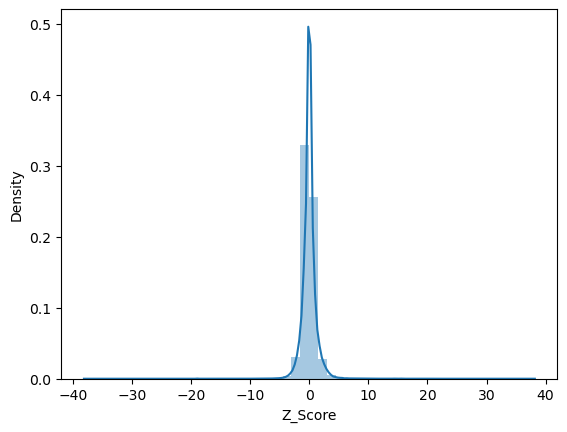

In [46]:
sns.distplot(df["Z_Score"])

#### From the density plot of the Z Score we can assume it to follow standard normal distribution(approx)

#### Defining Signal using the thresholds as z upper value and z lower value using the assumption that z score follows standard distribution and considering the level of significance to be 1% for  with threshold would be +2.5 and -2.5(approx)

In [47]:
def signal(x):
    if x>2.5:
        return 1
    elif x<-2.5:
        return -1
    else:
        return 0
    
df["Signal"]=df.Z_Score.apply(signal)

#### Signal = 1 ---> It implies that if, z_score > 2.5 , then the current spread is more than the rolling average spread, so, SHORT BANK NIFTY and LONG NIFTY, similarly for Signal ---> -1 it will converse of this

In [48]:
df["Signal"].value_counts()

 0    663339
 1     14372
-1     11362
Name: Signal, dtype: int64

#### We are executing total 25734 trades

### Calculating P/L

In [49]:
df["P/L"] = (df["spread"]) * (df["tte"] ** 0.7) * (df["Signal"])

#### Multiply by SIGNAL as if, we are not executing trade still P/L will not equal to 0. Therefore to take the effect of trade into consideration we need to multiply by indicator function(here it is SIGNAL).

## Model 2 - Predicted Spread using Linear Regression

In [108]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [109]:
df1 = pd.read_parquet("data.parquet")
df1.head()

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27


In [110]:
df1 = df1.fillna(method = "ffill")

In [111]:
df1 = df1.reset_index()

<Axes: xlabel='banknifty', ylabel='nifty'>

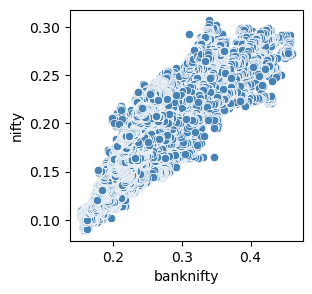

In [127]:
plt.figure(figsize=(3,3))
sns.scatterplot(df1, x= "banknifty", y = "nifty", color = "steelblue")

#### We can easily see the multicolinearity between Bank NIFTY and NIFTY

In [113]:
df1["Spread"] = df1["banknifty"] - df1["nifty"]

<Axes: xlabel='banknifty', ylabel='Spread'>

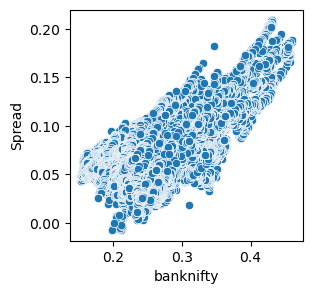

In [114]:
plt.figure(figsize=(3,3))
sns.scatterplot(df1, x= df1["banknifty"], y = df1["Spread"])

<Axes: xlabel='nifty', ylabel='Spread'>

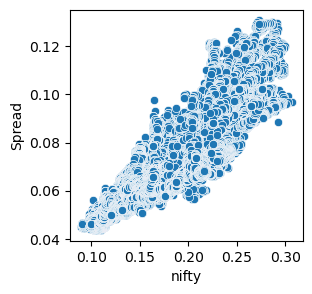

In [126]:
plt.figure(figsize=(3,3))
sns.scatterplot(df1, x= df1["nifty"], y = df1["Spread"])

Text(0.5, 1.0, 'Correlation Matrix of Bank NIFTY vs NIFTY')

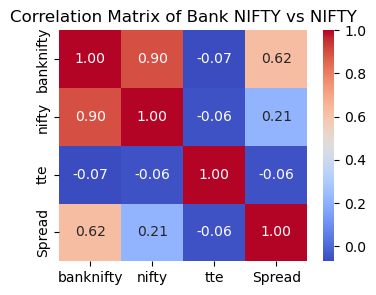

In [116]:
fig, ax = plt.subplots(figsize=(4,3))
sns.heatmap(df1.corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Correlation Matrix of Bank NIFTY vs NIFTY')

#### Splitting testing and training data and fitting linear regression and predicting spread

In [117]:
X = df1[['banknifty', 'tte']]
y = df1['Spread']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

# Model training
model = LinearRegression()
model.fit(X_train, y_train)

df1['Spread'] = model.predict(X)


In [121]:
df1['P/L'] = df1['Spread'] * (df1['tte'] ** 0.7) 

#### Performance Evaluation

In [123]:
base_profit = df['P/L'].sum()
advanced_profit = df1['P/L'].sum()
base_sharpe = df['P/L'].mean() / df['P/L'].std()
advanced_sharpe = df1['P/L'].mean() / df1['P/L'].std()
base_drawdown = np.min(np.cumsum(df['P/L']) - np.cumsum(df['P/L'].expanding().max()))
advanced_drawdown = np.min(np.cumsum(df1['P/L']) - np.cumsum(df1['P/L'].expanding().max()))

#### Comparing both the models Based model vs Fitted model  

In [124]:
print("Base Model - Total P/L: {:.2f}, Sharpe Ratio: {:.2f}, Drawdown: {:.2f}".format(base_profit, base_sharpe, base_drawdown))
print("Advanced Model - Total P/L: {:.2f}, Sharpe Ratio: {:.2f}, Drawdown: {:.2f}".format(advanced_profit, advanced_sharpe, advanced_drawdown))

Base Model - Total P/L: 354305.74, Sharpe Ratio: 0.04, Drawdown: -166175989.48
Advanced Model - Total P/L: 319319.73, Sharpe Ratio: 2.05, Drawdown: -562949.11


### Conclusion: P/L of our base model is coming out be slightly higher than the fitted model but other parameters such as Sharpe Ratio and Drawdown are better for the fitted model.